# Cloud Optical Thickness Prediction from Imaging Satellite Instruments

In [1]:
import os
import math
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.special import logit
from multiprocessing import Process
from time import perf_counter

import matplotlib.pyplot as plt

In [37]:
# Description: 1 layer - 64 neurons, 200 epochs, cut off = -3, lr = 0.0001
expname = '053107oci'  # Define your experiment name to save models and results
save_pth = '/Users/xingyanli/Lab/gestar2_regression/' # the directory to save models and results

In [3]:
file_path ='rt_nn_cloud_training_data_20230310.nc'
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:                        (npoints: 250000, nbands_oci: 223, nbands_modis: 11, nbands_viirs: 10)
Coordinates:
  * nbands_oci                     (nbands_oci) float32 350.0 ... 2.261e+03
  * nbands_modis                   (nbands_modis) float32 412.0 ... 2.13e+03
  * nbands_viirs                   (nbands_viirs) float32 412.0 ... 2.25e+03
Dimensions without coordinates: npoints
Data variables:
    solar_zenith_angle             (npoints) float32 ...
    viewing_zenith_angle           (npoints) float32 ...
    relative_azimuth_angle         (npoints) float32 ...
    albedo_type                    (npoints) int16 ...
    oci_reflectances               (nbands_oci, npoints) float32 ...
    modis_reflectances             (nbands_modis, npoints) float32 ...
    viirs_reflectances             (nbands_viirs, npoints) float32 ...
    scene_type                     (npoints) int16 ...
    log10_cloud_optical_thickness  (npoints) float32 ...
    spress                         (npoints) float32 ...
    h2o                            (npoints) float32 ...
    o3                             (npoints) float32 ...
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 Created 20230310
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

In [4]:
# Define variables
oci_reflectances = ds["oci_reflectances"].values 
modis_reflectances = ds["modis_reflectances"].values 
viirs_reflectances = ds["viirs_reflectances"].values 
nbands_oci = ds["nbands_oci"].values
nbands_modis = ds["nbands_modis"].values
nbands_viirs = ds["nbands_viirs"].values
angles = ds[["solar_zenith_angle", "viewing_zenith_angle", "relative_azimuth_angle"]].to_array().values
h2o = ds["h2o"].values
o3 = ds["o3"].values
scene_type = ds["scene_type"].values
albedo_type = ds["albedo_type"].values
spress = ds["spress"].values
cot = ds["log10_cloud_optical_thickness"].values

In [5]:
print(oci_reflectances.shape)


(223, 250000)


In [6]:
# Use PCA to reduce dimension
# Dimensions: 100, 50, 10, 5
data_x = oci_reflectances.T
pca = PCA(n_components=50)
pca = pca.fit(oci_reflectances.T)
oci_dr = pca.transform(data_x)


In [42]:
eigenvalues = pca.explained_variance_ratio_
print(eigenvalues)



[9.28804728e-01 5.34061997e-02 6.20592233e-03 4.43956591e-03
 1.95573019e-03 1.80530133e-03 8.69972046e-04 7.37332723e-04
 6.86561161e-04 3.19199371e-04]


In [7]:
# Use PCA to reduce dimension
# Dimensions: 100, 50, 10, 5
data_x = oci_reflectances.T
pca = PCA(n_components=10)
pca = pca.fit(oci_reflectances.T)
oci_dr = pca.transform(data_x)


In [8]:
print(oci_dr.shape)

(250000, 10)


### Data preprocess

In [9]:
# Define a minmax scaler
def minmaxscaler(reflectances):
        if len(reflectances.shape) == 1:
                reflectances_sc = (reflectances-reflectances.min())/(reflectances.max() - reflectances.min())
        else:
                reflectances_sc = []
                for i in range(len(reflectances)):
                        reflectances_sc_tem = (reflectances[i]-reflectances[i].min())/(reflectances[i].max()-reflectances[i].min())
                        reflectances_sc.append(reflectances_sc_tem)
        return np.array(reflectances_sc)
                

In [10]:
# Define labels for albedo type
land = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,18]
snow = [15,19,20]
desert = [16, 16]
ocean_water = [17, 17]
albedo = [land, snow, desert, ocean_water]

def albedo_category(albedo_type):
    albedo_type_sc = []
    for k in range(len(albedo)):
        i = 0
        albedo_1hot = []
        for i in range(len(albedo_type)):
            if albedo_type[i] in albedo[k]:
                albedo_1hot.append(1)
            else:
                albedo_1hot.append(0)
        albedo_type_sc.append(albedo_1hot)
    return np.array(albedo_type_sc)

In [11]:
"""
Reflectances, h2o, o3, spress: minmax normalize to [0,1]
Angles: take cosine and normalize to [0,1]
scen_type: no preprocessing
albedo_type: break down into 4 categories
cot: set 0 as -3
"""
oci_reflectances_sc = minmaxscaler(oci_dr.T)
h2o_sc = minmaxscaler(h2o)
o3_sc = minmaxscaler(o3)
spress_sc = minmaxscaler(spress)
angles_sc = minmaxscaler(np.cos(angles))
albedo_type_sc = np.float32(albedo_category(albedo_type))

In [12]:
cot_sc = np.nan_to_num(cot, nan=-2) 
max_value = cot_sc.max()
min_value = cot_sc.min()
cot_sc = minmaxscaler(cot_sc)

## Concatenate variables and split training-testing dataset

In [13]:
X = np.concatenate((oci_reflectances_sc, h2o_sc[None, :], o3_sc[None, :], spress_sc[None, :], albedo_type_sc, angles_sc), axis=0) # n x m, where n = 22
# X = np.transpose(X) # transpose into a m x n matrix , n = 22 (aka features) and m = rows (aka observations)
X = np.float32(X)
# Y represents the response vector (binary),,,, m by 1, m = rows (aka observations)
Y = cot_sc
# Y = np.reshape(Y, (-1, 1)) # reshape to m x 1 array

In [14]:
print(X.shape, Y.shape)

(20, 250000) (250000,)


In [15]:
X = np.transpose(X)

In [16]:
Y = np.reshape(Y, (-1, 1))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

# Prepare Data for Training

In [18]:
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))

In [19]:
dataset_train = Data.TensorDataset(X_train_t, y_train_t)
dataset_val = Data.TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(dataset = dataset_train, batch_size = 64, shuffle=True, pin_memory=True)
validate_loader = DataLoader(dataset = dataset_val, batch_size = 64, shuffle=True, pin_memory=True)

# Network

In [20]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_size, 32),
      # nn.BatchNorm1d(64),
      nn.ReLU(),
      nn.Linear(32, 64),
      # nn.BatchNorm1d(64),
      nn.ReLU(),
      nn.Linear(64, 128),
      # nn.BatchNorm1d(32),
      nn.ReLU(),
      nn.Linear(128, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

# Optimization

In [21]:
# Initialize the MLP
mlp = MLP(input_size=X_train_t.shape[1])
  
# Define the loss function and optimizer
loss_function = nn.L1Loss() # Pay attention to the threshold between cloud and non-cloud pxiels # add penalty to -1.5
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.00001)

In [22]:
print(mlp )

MLP(
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [23]:
# Run the training loop
train_loss_all = []
valid_loss_all = []
for epoch in range(200): 
  
  # Print epoch
  print(f'Starting epoch {epoch+1}')
  
  # Set current loss value
  train_loss = 0.0
  valid_loss = 0.0
  train_num = 0
  valid_num = 0
  
  # Iterate over the DataLoader for training data
  for step, (b_x,b_y) in enumerate(train_loader):
    output = mlp(b_x)*(max_value-min_value)+min_value
    ground_truth = b_y*(max_value-min_value)+min_value
    loss = loss_function(output, ground_truth)
    optimizer.zero_grad
    loss.backward()
    optimizer.step()
    train_loss +=loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_all.append(train_loss / train_num)

  for setp, (c_x, c_y) in enumerate(validate_loader):
    output_valid = mlp(c_x)*(max_value-min_value)+min_value
    loss_v = loss_function(output_valid,(c_y*(max_value-min_value)+min_value))
    valid_loss +=loss_v.item() * c_x.size(0)
    valid_num += c_x.size(0)

  valid_loss_all.append(valid_loss / valid_num) # revise for other experiments
  print("Train Loss: {}, Valid Loss: {}".format ((train_loss / train_num), (valid_loss / valid_num)))  

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Train Loss: 1.11985330864871, Valid Loss: 1.0473726269022623
Starting epoch 2
Train Loss: 0.9989545635124489, Valid Loss: 0.9834439272753398
Starting epoch 3
Train Loss: 0.9879766909818296, Valid Loss: 0.989749256078932
Starting epoch 4
Train Loss: 0.9821721868620978, Valid Loss: 0.9806158594173855
Starting epoch 5
Train Loss: 0.9692073003648829, Valid Loss: 0.9619065706189474
Starting epoch 6
Train Loss: 0.9453761438475715, Valid Loss: 0.9272318854056464
Starting epoch 7
Train Loss: 0.8938950392228586, Valid Loss: 0.8582367524337768
Starting epoch 8
Train Loss: 0.8150826983437715, Valid Loss: 0.790426630821228
Starting epoch 9
Train Loss: 0.7779817812940809, Valid Loss: 0.7720798002645705
Starting epoch 10
Train Loss: 0.7560224075282062, Valid Loss: 0.7754404642020332
Starting epoch 11
Train Loss: 0.7420152455414666, Valid Loss: 0.7005207636684841
Starting epoch 12
Train Loss: 0.7277251970941049, Valid Loss: 0.6675975586658054
Starting epoch 13
Train Loss: 0.709837411

In [24]:
PATH = './models/{}_oci.pth'.format(expname)
torch.save(mlp.state_dict(), PATH)

# Training Loss Plot

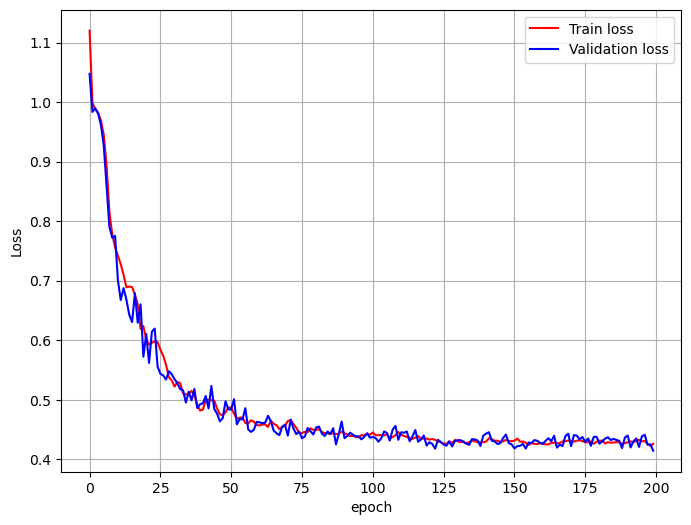

In [38]:
plt.figure(figsize = (8,6))
plt.plot(train_loss_all, 'r-', label = 'Train loss')
plt.plot(valid_loss_all, 'b-', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig('/Users/xingyanli/Lab/gestar2_regression/results/{}_loss.png'.format(expname))
plt.show()

# Test

In [26]:
mlp = MLP(input_size=X_train_t.shape[1])
mlp.load_state_dict(torch.load('./models/{}_oci.pth'.format(expname)))

<All keys matched successfully>

In [27]:

# Test data loader
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))
dataset_test = Data.TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(dataset = dataset_test, batch_size = len(y_test_t), shuffle=True, pin_memory=True)

# Load model
test_loss = 0.0
test_num = 0
for step, (d_x,d_y) in enumerate(test_loader):
    output_test = mlp(d_x)*(max_value-min_value)+min_value
    target = d_y*(max_value-min_value)+min_value
    output_test = output_test.detach().cpu().numpy()
    target = target.detach().cpu().numpy()


In [28]:
MSE = np.square(np.subtract(target,output_test)).mean() 
RMSE = math.sqrt(MSE)
print("MSE: {}, RMSE: {}".format(MSE, RMSE))

MSE: 0.5723925828933716, RMSE: 0.7565663109690859


In [29]:
threshold = -1.5
# MSE and RMSE for predicted values >= -1.5, the threshold of cloud-free and cloudy pixels
output_COT = []
target_COT = []
for m in range (len(target)):
    if output_test[m] >= threshold:
        target_COT.append(target[m])
        output_COT.append(output_test[m])
MSE_COT = np.square(np.subtract(target_COT,output_COT)).mean() 
RMSE_COT = math.sqrt(MSE)

print("MSE_cloudy: {}, RMSE_cloudy: {}".format(MSE_COT, RMSE_COT))

MSE_cloudy: 0.5847982168197632, RMSE_cloudy: 0.7565663109690859


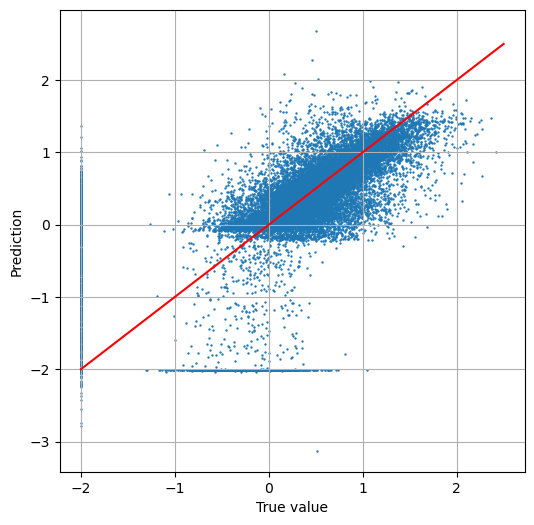

In [39]:
plt.figure(figsize = (6,6))
plt.scatter(target, output_test, s=0.5)
plt.plot([-2,2.5], [-2,2.5], 'r-')
plt.grid()
plt.xlabel('True value')
plt.ylabel('Prediction')
plt.savefig("./results/{}_scatter.png".format(expname))
plt.show()


In [31]:
wrong_pixel = []
for i in range (len(target)):
    if (target[i] >= threshold) & (output_test[i] < threshold):
        wrong_pixel.append(1)
    elif (target[i]< threshold) & (output_test[i] >= threshold):
        wrong_pixel.append(1)
    else: 
        wrong_pixel.append(0)

In [32]:
wrong_pixel_ratio = np.sum(wrong_pixel)/len(target)
wrong_pixel_ratio

0.12396

In [33]:
pool_target = {}
pool_output = {}
MSE_hex = []
RMSE_hex = []
bins =np.histogram_bin_edges(np.linspace(-2, 2.5, 9), bins=9)
for i in range (9):
    pool_target[i] = []
    pool_output[i] = []
    for j in range (len(target)):
        if (target[j]>=bins[i]) & (target[j] < bins[i+1]):
            pool_target[i].append(target[j])
            pool_output[i].append(output_test[j])
    MSE_hex.append(np.square(np.subtract(np.array(pool_target[i]),np.array(pool_output[i]))).mean())
    RMSE_hex.append(math.sqrt(MSE_hex[i]))

In [34]:
np.transpose(RMSE_hex)

array([1.06525037, 0.91793489, 1.03545729, 0.90888499, 0.57772579,
       0.3651331 , 0.39893133, 0.59255344, 0.96117612])

In [35]:
test_truth = np.hstack((target, output_test))
test_truth

array([[ 1.35813   ,  1.3692107 ],
       [ 0.987221  ,  1.0696926 ],
       [ 0.27429605,  0.6189518 ],
       ...,
       [ 0.769187  ,  0.8877015 ],
       [ 1.48014   ,  1.330338  ],
       [-2.        , -2.0094767 ]], dtype=float32)

In [40]:
np.savetxt('./results/{}.csv'.format(expname), test_truth,  delimiter=',')
